In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
result_df = pd.read_csv("../../data/scheduling/output/result.csv")
result_df

,Unnamed: 0,Unnamed: 0.1,day,shift,subject,level,student,teacher,is_primary_slot,actual_subject,slot_type,is_prefer
0,0,0,2,1,math,elemetary,st_2,Teacher_8,1,math,sd_slot,0
1,1,1,2,4,english,elemetary,st_5,Teacher_11,1,english,seasonal_slot,0
2,2,2,2,2,science,elemetary,st_7,Teacher_8,1,science,sd_slot,0
3,3,3,2,2,english,elemetary,st_11,Teacher_11,1,english,sd_slot,1
4,4,4,2,1,math,elemetary,st_14,Teacher_8,1,math,sd_slot,0
...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,132,14,1,english+social_science,elemetary,st_18,Teacher_2,0,social_science,sd_slot,0
133,133,133,14,2,social_science,middle,st_23,Teacher_2,0,social_science,sd_slot,0
134,134,134,14,1,social_science,middle,st_23,Teacher_13,0,social_science,sd_slot,0
135,135,135,14,3,science,middle,st_24,Teacher_13,0,science,sd_slot,0


## [Hard constraints] 90% slot allocate at the primary time & 10% allocate at the secondary time


The primary time = 85% slots at first half + 50% slots at second half

 - first half: 80% first days in the period.
 - second half: 20% remain days in the period.

In [3]:
import sys
sys.path.append("../..") #internal/scheduling
sys.path.append("../../job/bestco")

from job.bestco.config  import NUM_TEACHER, NUM_DAY, NUM_STUDENT, NUM_SUBJECT, NUM_GRADE, NUM_SHIFT, SHIFT_MAPPING, SUBJECT_MAPPING, PERCENT_SLOT_AT_PRI, NUM_DAY_FIRST_HALF, NUM_SHIFT_FIRST_HALF, NUM_DAY_SECOND_HALF, NUM_SHIFT_SECOND_HALF
from job.bestco.utils import get_all_stu_slot


In [4]:


# count slot per day
count_df = result_df.groupby(["student", "is_primary_slot"]).size().reset_index(name="Time")

# get max slot of each student (seasonal slot + sd slot)
student_csv_path = "../../data/scheduling/input/student_course_formated.csv"
stu_slot = get_all_stu_slot(stu_path=student_csv_path)
stu = [f"st_{i+1}" for i in range(len(stu_slot))]
labels = stu
primary_slot = [0.0] * NUM_STUDENT
secondary_slot = [0.0] * NUM_STUDENT

# get percentage of primary time slot and secondary time slot
df = pd.DataFrame(list(zip(stu, stu_slot)), columns =['student', 'num_slot'])
percent_df = df.merge(right=count_df, on=["student"])
percent_df["percent_slot"] = percent_df.apply(lambda row: round(100*row["Time"]/row["num_slot"], 2), axis=1)


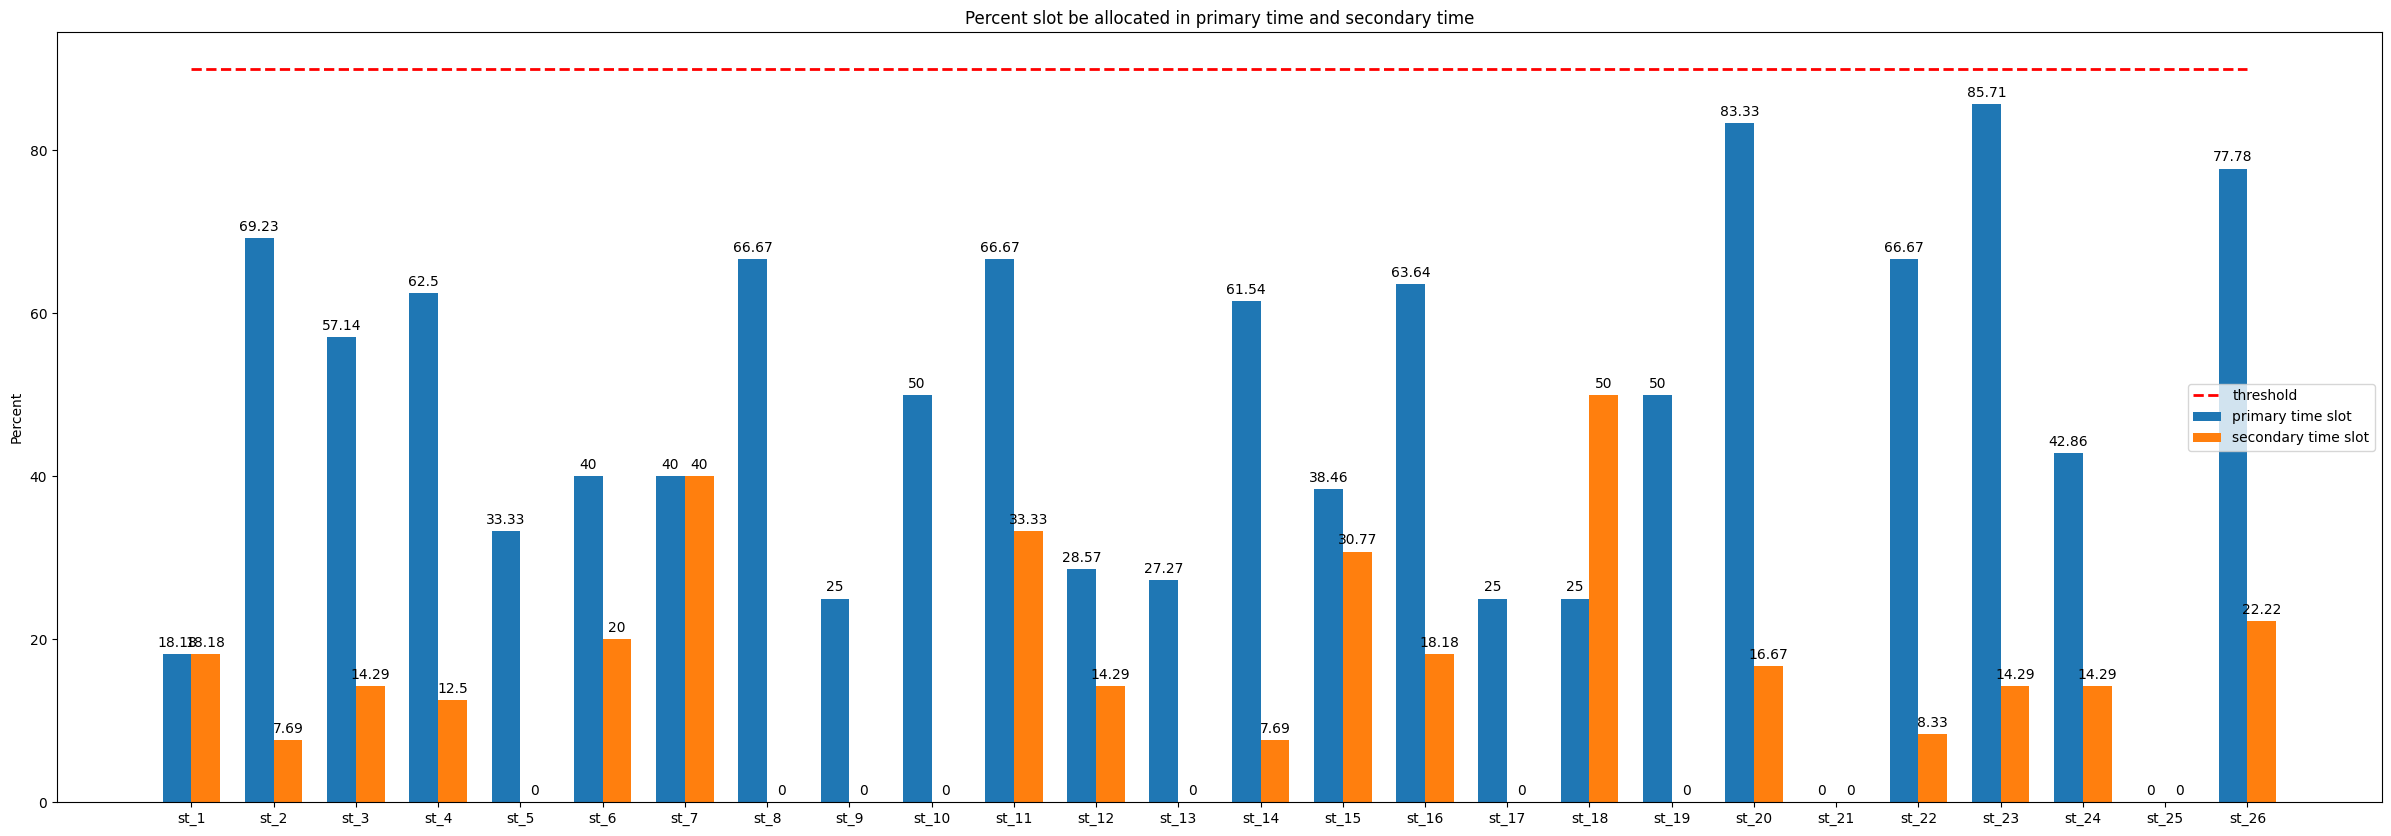

In [5]:
import matplotlib.pyplot as plt
import numpy as np


labels = stu
threshold = [90.0] * NUM_STUDENT
for i in range(len(percent_df)):
    stu_idx = int(percent_df["student"][i].split("_")[1]) - 1
    if (percent_df["is_primary_slot"][i] == 1):
        primary_slot[stu_idx] = percent_df["percent_slot"][i]
    else:
        secondary_slot[stu_idx] = percent_df["percent_slot"][i]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.bar(x - width/2, primary_slot, width, label='primary time slot')
rects2 = ax.bar(x + width/2, secondary_slot, width, label='secondary time slot')

ax.plot(labels, threshold, color ='red', markeredgewidth=3, linewidth = 2, linestyle = "--", label = "threshold")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Percent slot be allocated in primary time and secondary time')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

## [Hard contraints] Slot per day per student ≤ slot apply / number day.

In [6]:
import sys
sys.path.append("../..") #internal/scheduling
sys.path.append("../../job/bestco")

from job.bestco.config  import NUM_TEACHER, NUM_DAY, NUM_STUDENT, NUM_SUBJECT, NUM_GRADE, NUM_SHIFT, SHIFT_MAPPING, SUBJECT_MAPPING, PERCENT_SLOT_AT_PRI, NUM_DAY_FIRST_HALF, NUM_SHIFT_FIRST_HALF, NUM_DAY_SECOND_HALF, NUM_SHIFT_SECOND_HALF
from job.bestco.utils import get_stu_slot_per_day, get_all_stu_slot, get_stu_avail_day

In [7]:
# number slot per day expected
student_csv_path = "../../data/scheduling/input/student_course_formated.csv"
all_stu_slot = get_all_stu_slot(stu_path=student_csv_path)
stu_day = get_stu_avail_day(stu_path=student_csv_path)
stu_slot_per_day = get_stu_slot_per_day(stu_day=stu_day, all_stu_slot=all_stu_slot)
stu = [f"st_{i+1}" for i in range(len(stu_slot))]

# actual max slot per day.
df = result_df 
stu_max_slot = df.groupby(by=["student", "day"]).size().reset_index(name="Time").groupby(by=["student"]).max().reset_index()

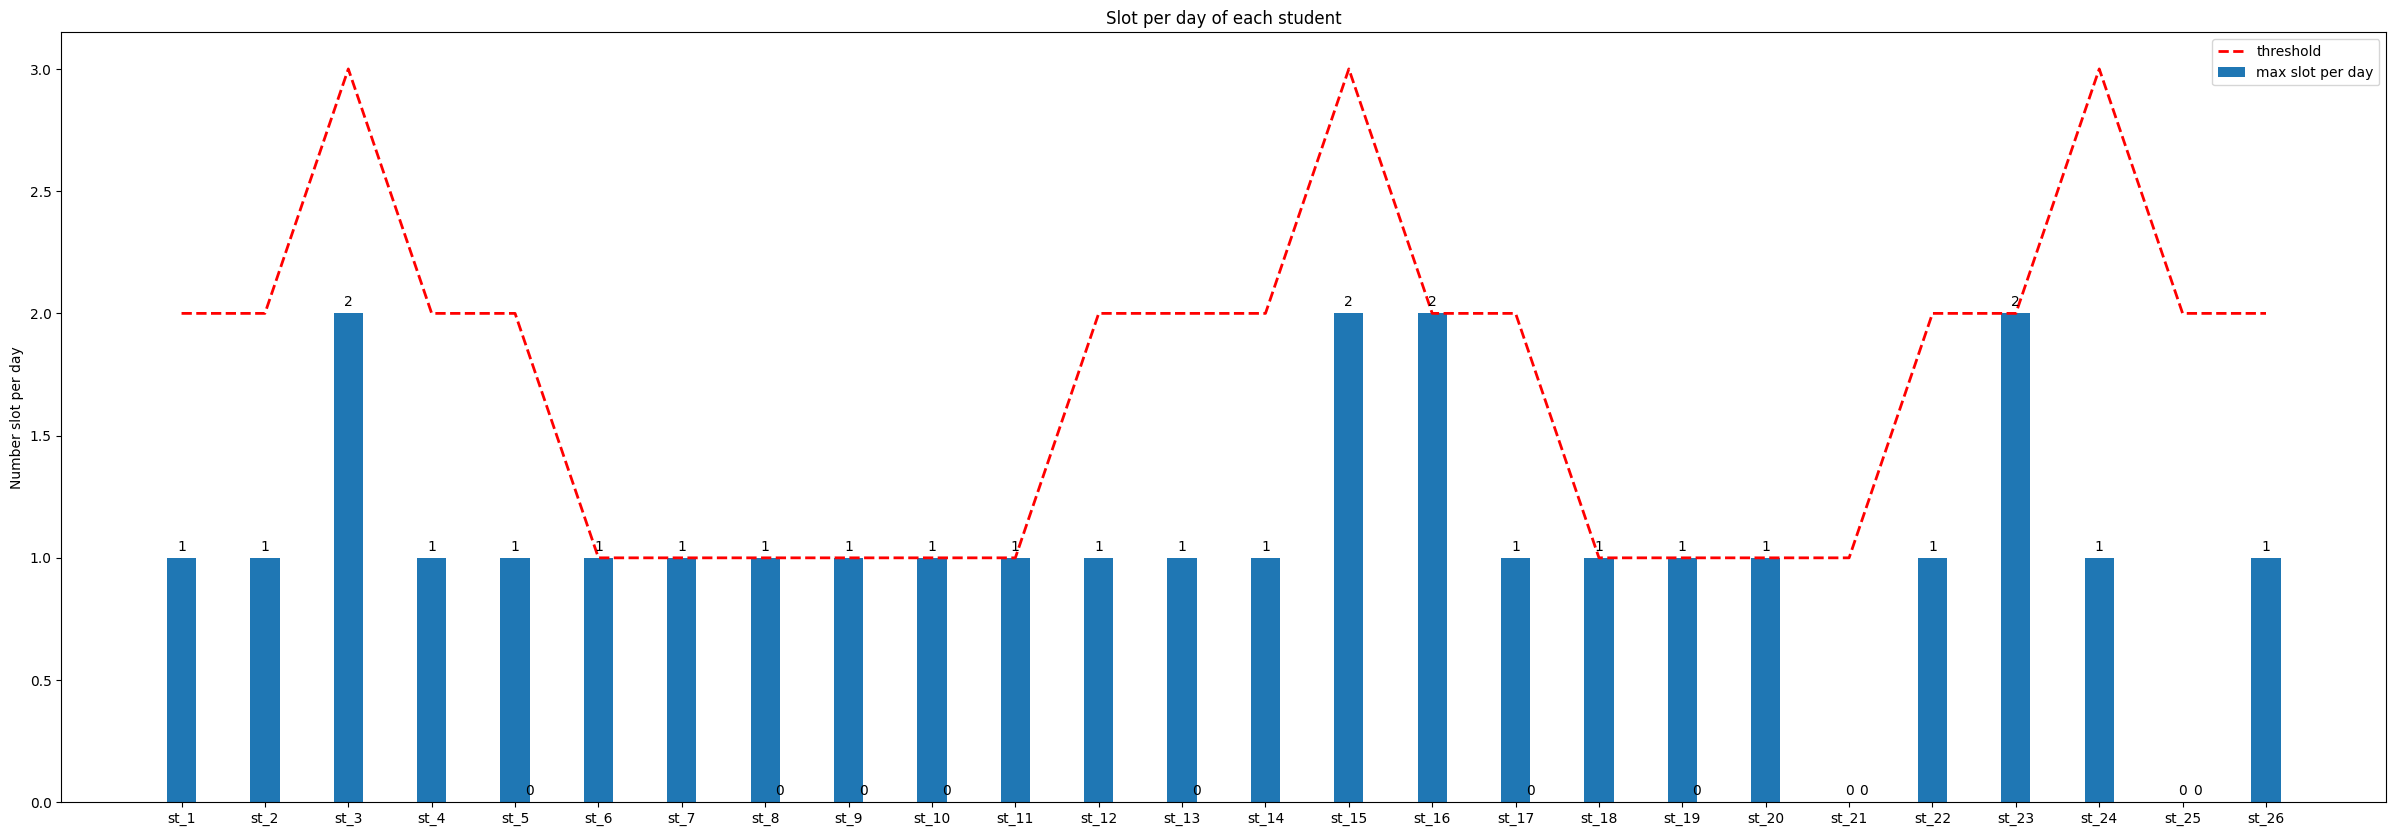

In [8]:
import matplotlib.pyplot as plt
import numpy as np


labels = stu
threshold = stu_slot_per_day
max_slot_list = [0] * NUM_STUDENT
for i in range(len(stu_max_slot)):
    stu_idx = int(stu_max_slot["student"][i].split("_")[1]) - 1
    max_slot_list[stu_idx] = stu_max_slot["Time"][i]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects1 = ax.bar(x, max_slot_list, width, label='max slot per day')

ax.plot(labels, threshold, color ='red', markeredgewidth=3, linewidth = 2, linestyle = "--", label = "threshold")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number slot per day')
ax.set_title('Slot per day of each student')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

In [9]:
#[Hard constraints] Student study a slot at a time.

## [Hard constraints] The student does not to be allocated slots greater than the number of slots which is registered.


In [10]:
import sys
sys.path.append("../..") #internal/scheduling
sys.path.append("../../job/bestco")

from job.bestco.config  import NUM_TEACHER, NUM_DAY, NUM_STUDENT, NUM_SUBJECT, NUM_GRADE, NUM_SHIFT, SHIFT_MAPPING, SUBJECT_MAPPING, PERCENT_SLOT_AT_PRI, NUM_DAY_FIRST_HALF, NUM_SHIFT_FIRST_HALF, NUM_DAY_SECOND_HALF, NUM_SHIFT_SECOND_HALF
from job.bestco.utils import get_all_stu_sub_slot

In [11]:
# count slot per day
stu_sub_slot = result_df.groupby(["student", "subject"]).size().reset_index(name="Time")

In [12]:
def get_sub_stu(result_df, sub_name):
    sub_list = [0] * NUM_STUDENT
    # count slot per day
    stu_sub_slot = result_df.groupby(["student", "subject"]).size().reset_index(name="Time")
    
    tmp = stu_sub_slot[stu_sub_slot["subject"] == sub_name].reset_index()
    for i in range(len(tmp)):
        stu_idx = int(tmp["student"][i].split("_")[1]) - 1
        sub_list[stu_idx] = int(tmp["Time"][i])
    return sub_list

In [13]:
# Total slot which be register
student_csv_path = "../../data/scheduling/input/student_course_formated.csv"
slot_of_each_subject = get_all_stu_sub_slot(stu_path=student_csv_path)

#SUBJECT_MAPPING = ['math', 'english', 'literature', 'science', 'social_science']
regis_math = [ slot_of_each_subject[i][0] for i in range(NUM_STUDENT) ]
regis_eng = [ slot_of_each_subject[i][1] for i in range(NUM_STUDENT) ]
regis_literature = [ slot_of_each_subject[i][2] for i in range(NUM_STUDENT) ]
regis_science = [ slot_of_each_subject[i][3] for i in range(NUM_STUDENT) ]
regis_social_science = [ slot_of_each_subject[i][4] for i in range(NUM_STUDENT) ]


# actual slot of each student
act_eng =  get_sub_stu(result_df, "english")
act_literature =  get_sub_stu(result_df, "literature")
act_math =  get_sub_stu(result_df, "math")
act_science =  get_sub_stu(result_df, "science")
act_social_science = get_sub_stu(result_df, "social_science")


In [82]:
stu

['st_1',
 'st_2',
 'st_3',
 'st_4',
 'st_5',
 'st_6',
 'st_7',
 'st_8',
 'st_9',
 'st_10',
 'st_11',
 'st_12',
 'st_13',
 'st_14',
 'st_15',
 'st_16',
 'st_17',
 'st_18',
 'st_19',
 'st_20',
 'st_21',
 'st_22',
 'st_23',
 'st_24',
 'st_25',
 'st_26']

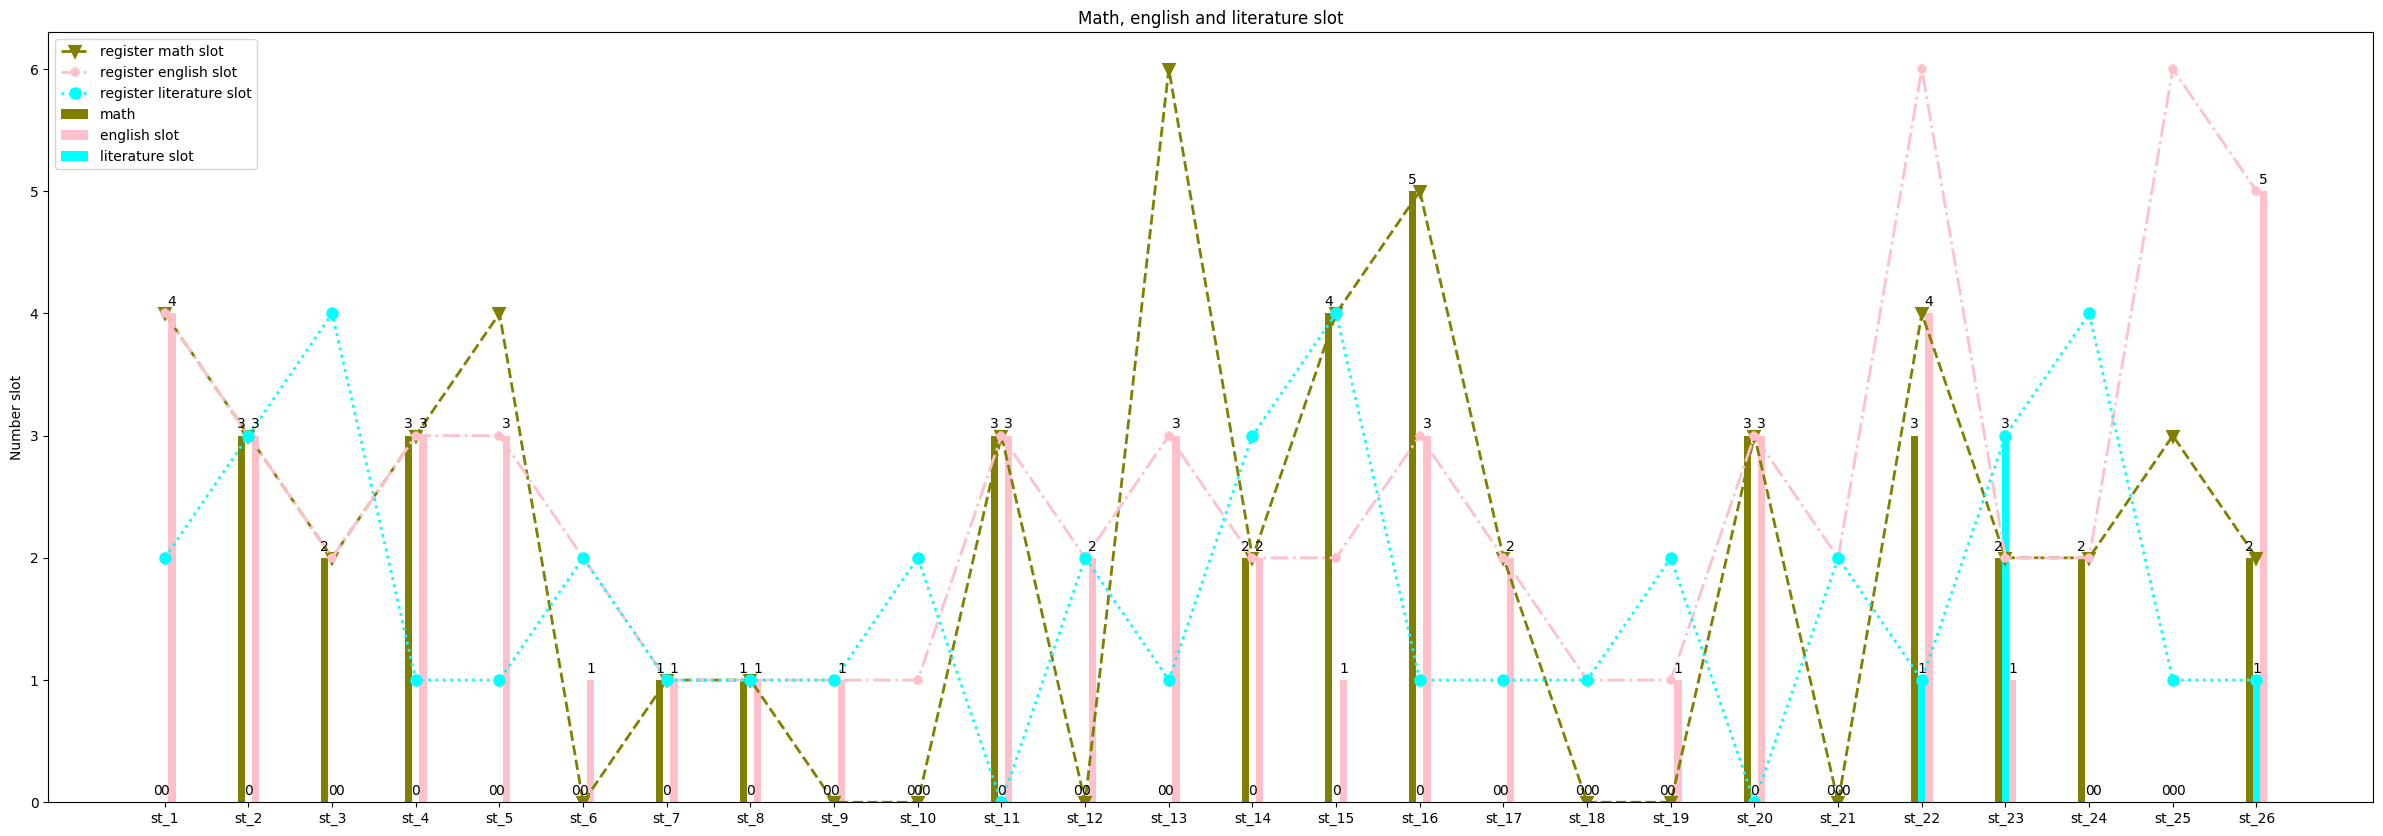

In [14]:
import matplotlib.pyplot as plt
import numpy as np


labels = stu

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects0 = ax.bar(x-width/4, act_math, width/4, label='math', color="olive")
rects1 = ax.bar(x+width/4, act_eng, width/4, label='english slot', color="pink")
rects2 = ax.bar(x, act_literature, width/4, label='literature slot', color="cyan")

ax.plot(labels, regis_math, color ='olive', markeredgewidth=3, linewidth = 2, marker="v", linestyle = "--", label = "register math slot")
ax.plot(labels, regis_eng, color ='pink', markeredgewidth=3, linewidth = 2, marker="*", linestyle = "-.", label = "register english slot")
ax.plot(labels, regis_literature, color ='cyan', markeredgewidth=3, linewidth = 2, marker="o", linestyle = ":", label = "register literature slot")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number slot')
ax.set_title('Math, english and literature slot')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)


plt.show()

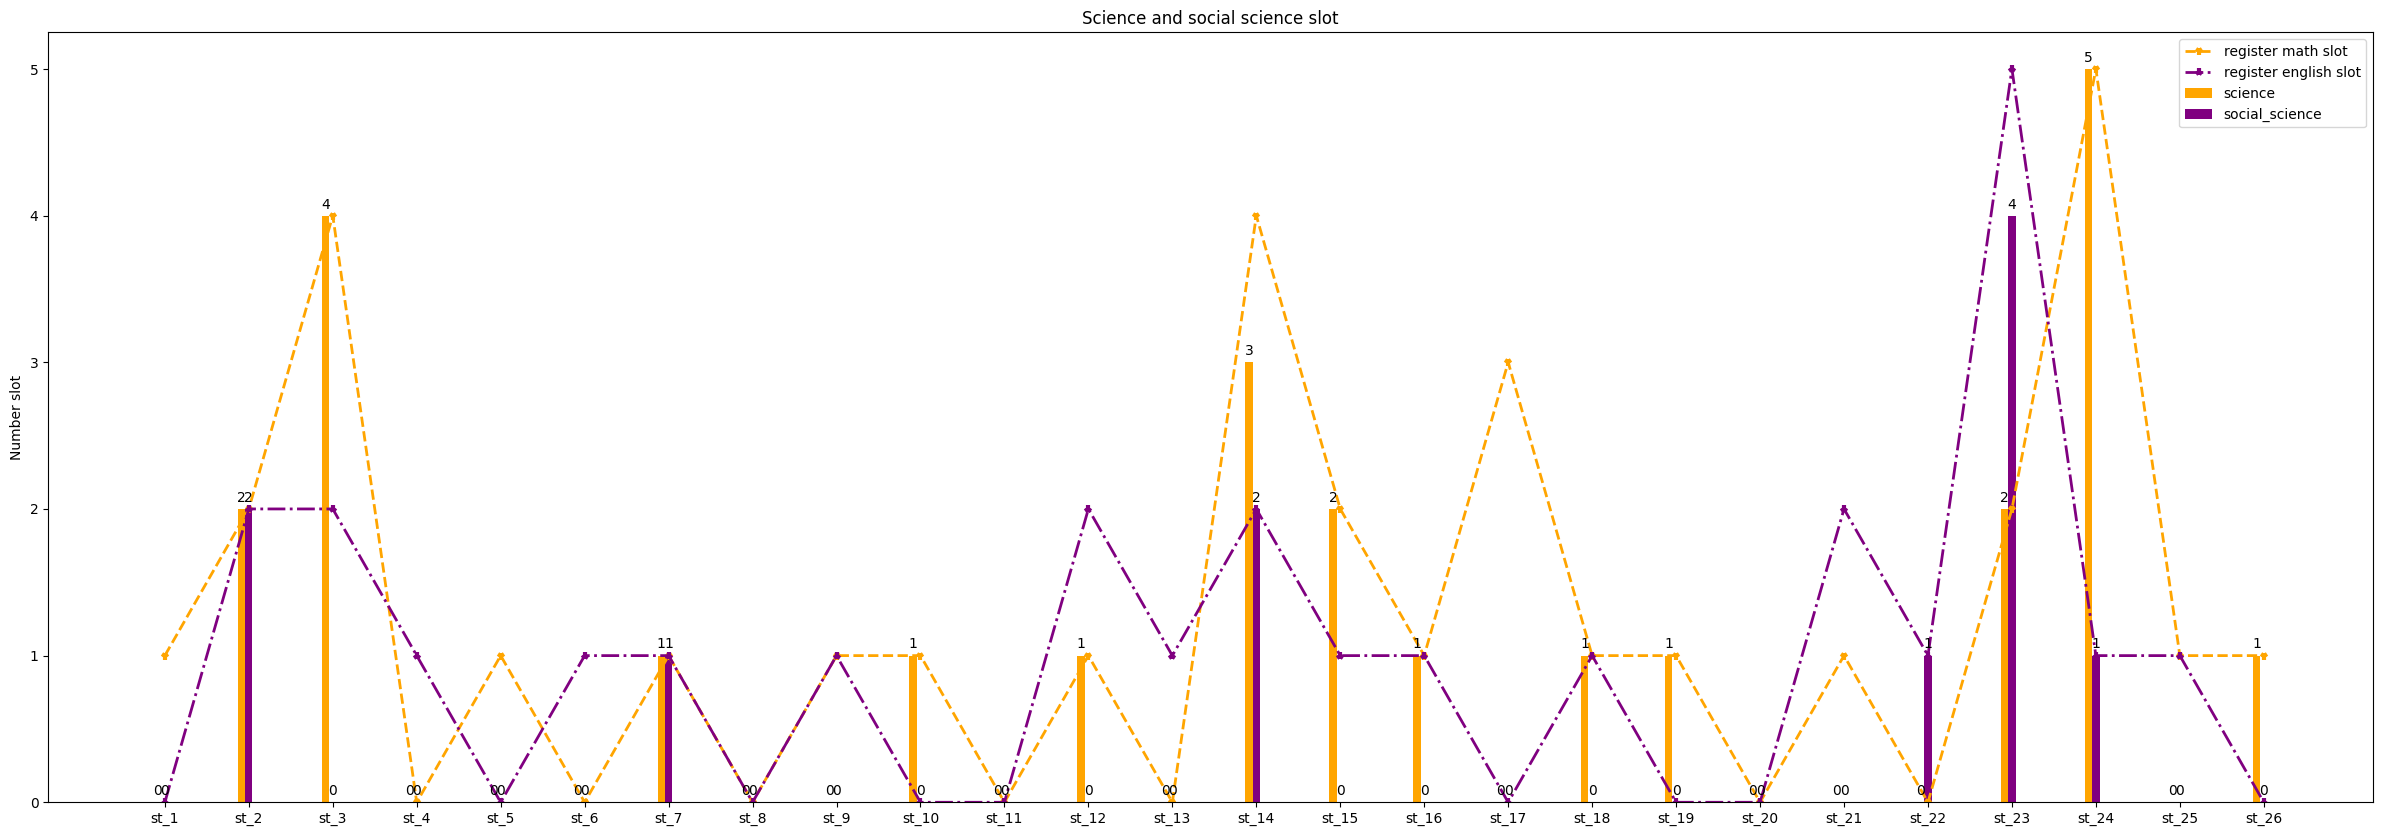

In [15]:
fig, ax = plt.subplots(figsize=(30, 10))

rects0 = ax.bar(x-width/4, act_science, width/4, label='science', color="orange")
rects1 = ax.bar(x, act_social_science, width/4, label='social_science', color="purple")

ax.plot(labels, regis_science, color ='orange', markeredgewidth=3, linewidth = 2, marker="1", linestyle = "--", label = "register math slot")
ax.plot(labels, regis_social_science, color ='purple', markeredgewidth=3, linewidth = 2, marker="2", linestyle = "-.", label = "register english slot")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number slot')
ax.set_title('Science and social science slot')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)

plt.show()

## [Hard Constraints] Teacher only handle one slot at a time

In [16]:
import sys
sys.path.append("../..") #internal/scheduling
sys.path.append("../../job/bestco")

import copy

from job.bestco.config  import NUM_TEACHER, NUM_DAY, NUM_STUDENT, NUM_SUBJECT, NUM_GRADE, NUM_SHIFT, SHIFT_MAPPING, SUBJECT_MAPPING, PERCENT_SLOT_AT_PRI, NUM_DAY_FIRST_HALF, NUM_SHIFT_FIRST_HALF, NUM_DAY_SECOND_HALF, NUM_SHIFT_SECOND_HALF
from job.bestco.utils import get_all_stu_slot

In [17]:
df = copy.deepcopy(result_df[["day", "shift", "subject", "teacher"]])
df = df.drop_duplicates().groupby(by=["teacher", "day", "shift"]).size().reset_index(name="num_slot").sort_values(by="num_slot", ascending=False)

In [18]:
values_list = list(df["num_slot"].value_counts().values)

In [19]:
count_list = list(df["num_slot"].value_counts().index.values)

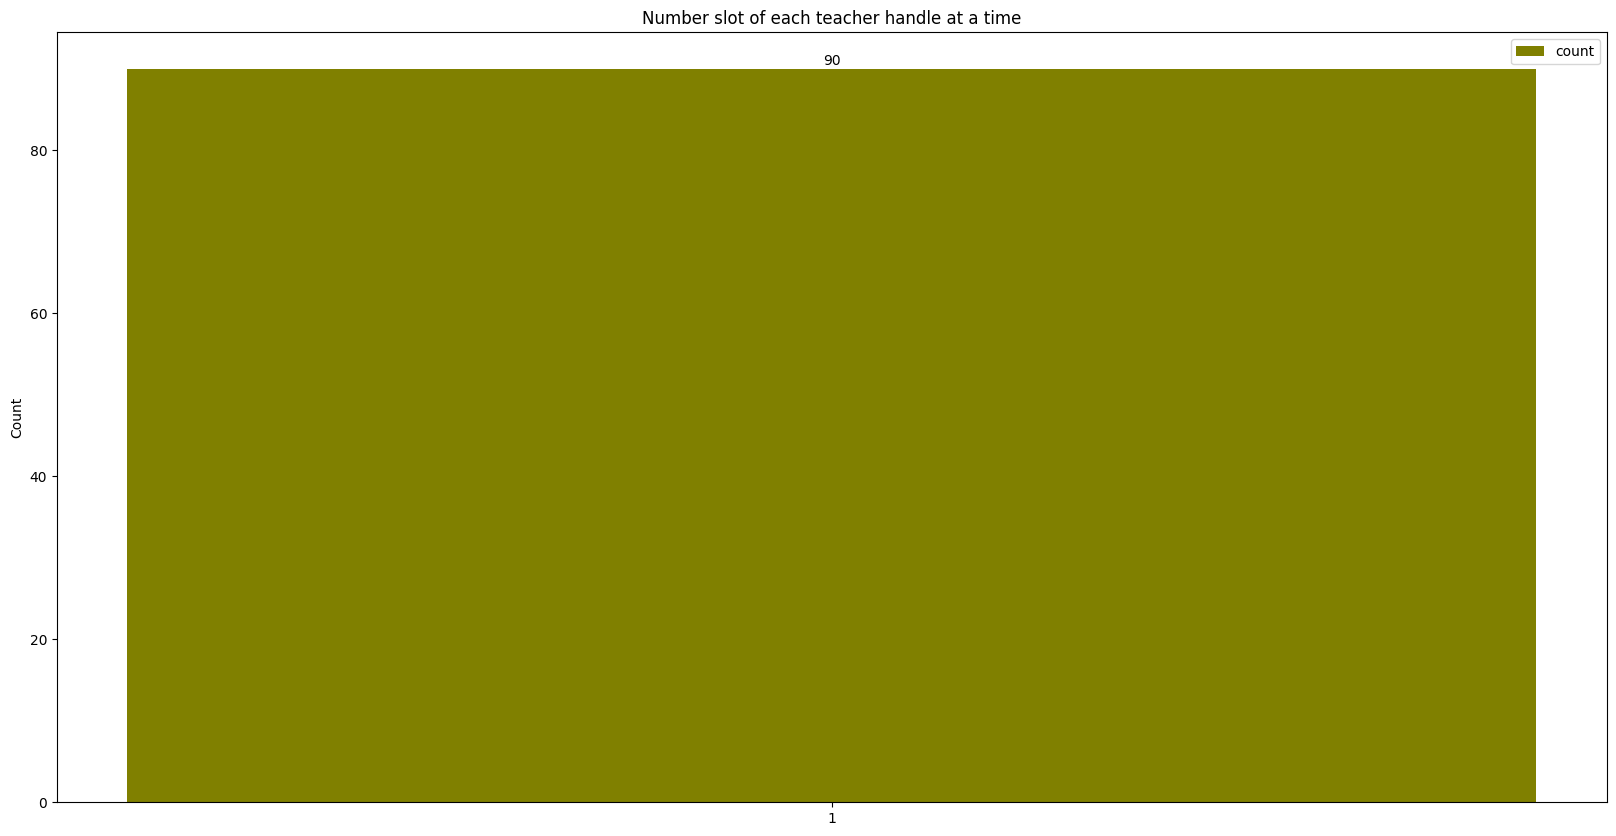

In [20]:
import matplotlib.pyplot as plt
import numpy as np

labels = count_list

x = np.arange(len(count_list))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects0 = ax.bar(x, values_list, width, label='count', color="olive")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Number slot of each teacher handle at a time')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects0, padding=1)


plt.show()

## [Hard Constraints] Student don't study with the same teacher consecutively

In [21]:
### The different of two slot which have same teacher of each student is greater than 1

df = copy.deepcopy(result_df[["day", "shift", "student", "teacher"]])

In [22]:
check_list = []
label_list = []

tmp = df.groupby(by=["student", "day", "teacher", "shift"])

for i in range(len(df)):
    value_tmp = tmp.get_group((df["student"][i], df["day"][i], df["teacher"][i], df["shift"][i])).sort_values(by=['shift']).reset_index()

    # iterator all slot which have the same day, teacher, subject of a student.
    # if there are any 2 slot consecutive => conflict the constraints
    check_list.append(0)
    label_list.append("_".join([str(df["student"][i]), str(df["day"][i]), str(df["teacher"][i])]))
    
    if (len(value_tmp) > 1):
        for k in range(len(value_tmp) - 1):        
            student = value_tmp["student"][k]
            slot1 = value_tmp["shift"][k]
            slot2 = value_tmp["shift"][k + 1]
            check_list[i] = 1 if (value_tmp["shift"][k + 1] - value_tmp["shift"][k]) == 1 else 0

In [23]:
check_list_0_values = list(filter(lambda value: value == 0, check_list))
check_list_1_values = list(filter(lambda value: value == 1, check_list))

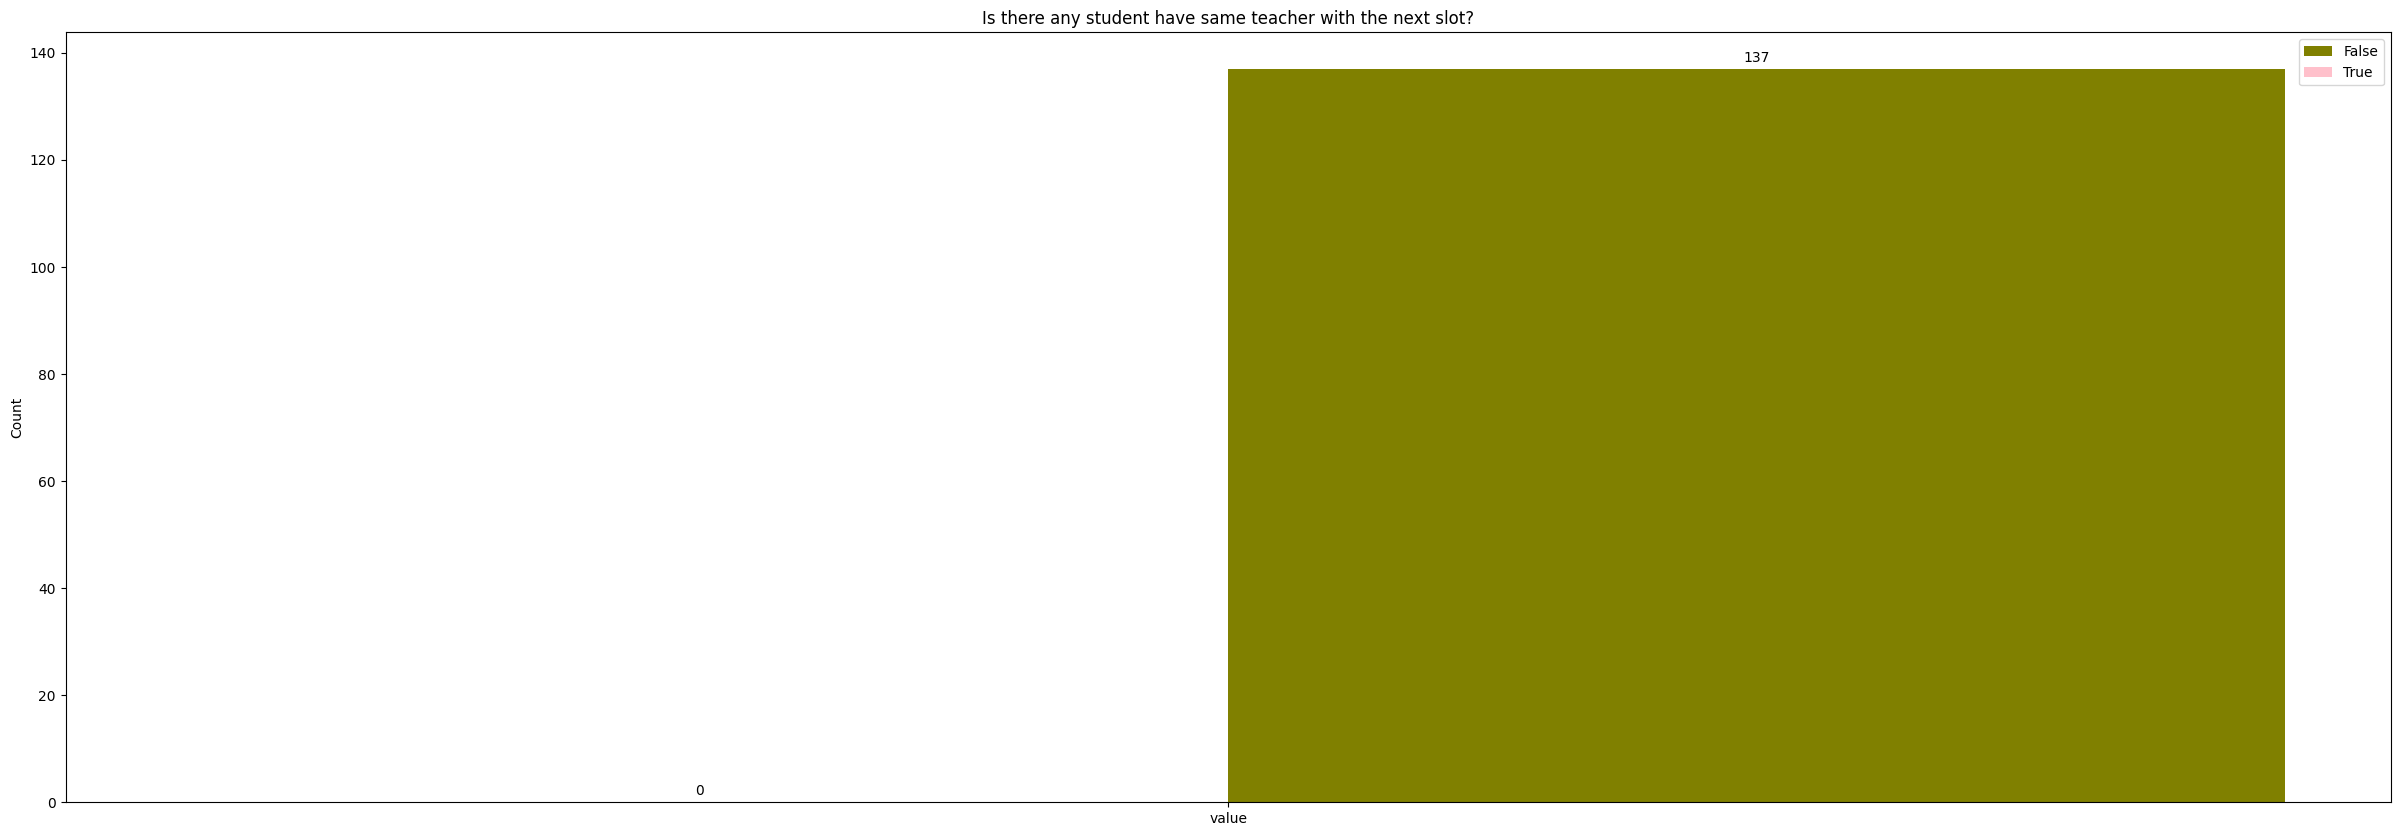

In [24]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["value"]

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects0 = ax.bar(x+(width/2), len(check_list_0_values), width, label='False', color="olive")
rects1 = ax.bar(x-(width/2), len(check_list_1_values), width, label='True', color="pink")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Is there any student have same teacher with the next slot?')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)

plt.show()

In [25]:
# Student don't study with the same subject consecutively

In [26]:
### The different of two slot which have same subject of each student is greater than 1

df = copy.deepcopy(result_df[["day", "shift", "student", "subject"]])

In [27]:
check_list = []
label_list = []

tmp = df.groupby(by=["student", "day", "subject", "shift"])

for i in range(len(df)):
    value_tmp = tmp.get_group((df["student"][i], df["day"][i], df["subject"][i], df["shift"][i])).sort_values(by=['shift']).reset_index()

    # iterator all slot which have the same day, teacher, subject of a student.
    # if there are any 2 slot consecutive => conflict the constraints
    check_list.append(0)
    label_list.append("_".join([str(df["student"][i]), str(df["day"][i]), str(df["subject"][i])]))
    
    if (len(value_tmp) > 1):
        for k in range(len(value_tmp) - 1):        
            student = value_tmp["student"][k]
            slot1 = value_tmp["shift"][k]
            slot2 = value_tmp["shift"][k + 1]
            check_list[i] = 1 if (value_tmp["shift"][k + 1] - value_tmp["shift"][k]) == 1 else 0

In [28]:
check_list_0_values = list(filter(lambda value: value == 0, check_list))
check_list_1_values = list(filter(lambda value: value == 1, check_list))

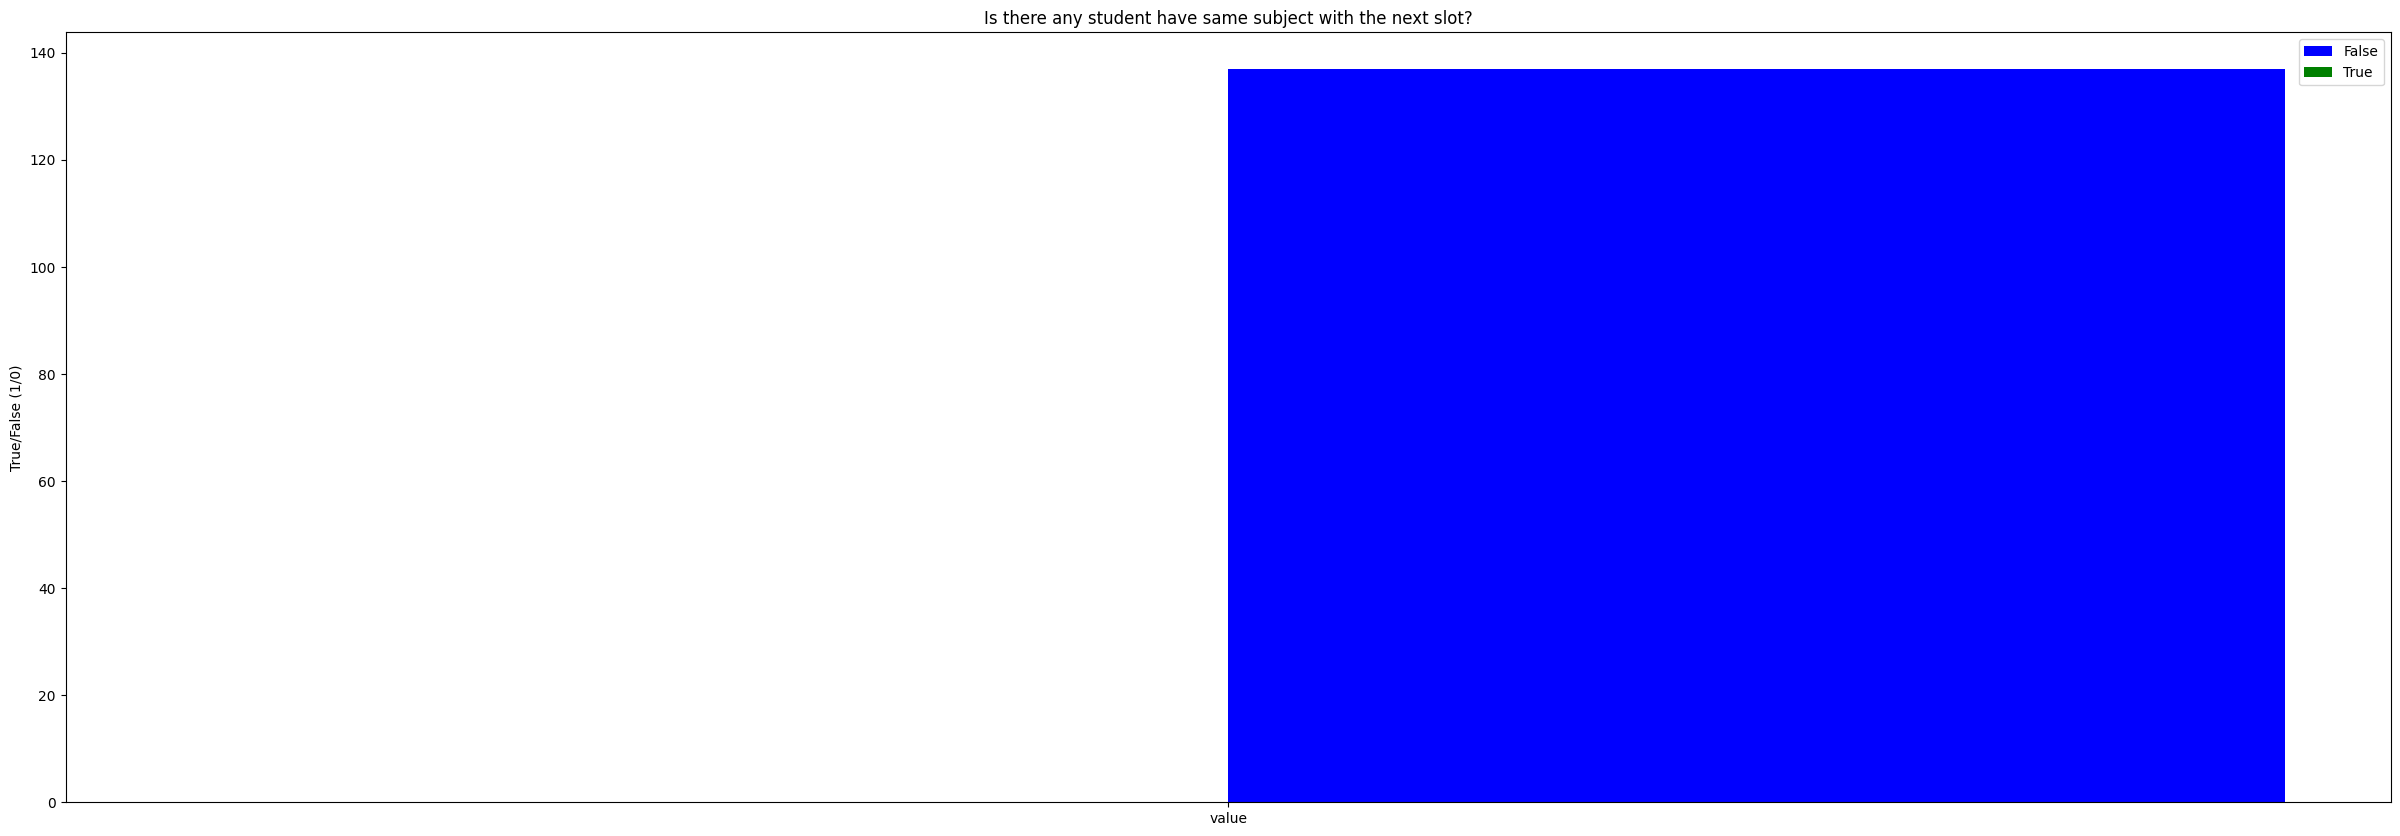

In [29]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["value"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(30, 10))
rects0 = ax.bar(x+(width/2), len(check_list_0_values), width, label='False', color="Blue")
rects1 = ax.bar(x-(width/2), len(check_list_1_values), width, label='True', color="Green")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('True/False (1/0)')
ax.set_title('Is there any student have same subject with the next slot?')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects0, padding=3)
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)


plt.show()

## [Soft constraint] minimize the remain slot of each student per subject

In [24]:
import sys

sys.path.append("../../job/bestco")
from utils import get_all_stu_sub_slot
from config import SUBJECT_MAPPING

In [25]:
def get_number_register_and_applie_slot(input_stu_course_path, result_path):
    register_slot=get_all_stu_sub_slot(input_stu_course_path)
    
    # allocated slot by from scheduling result
    slot = pd.read_csv(input_stu_course_path)
    slot = slot[["student", "subject"]].drop_duplicates().reset_index()[["student", "subject"]]
    slot["register_num"] = slot.apply(lambda row: register_slot[int(row["student"].split("_")[1]) - 1][SUBJECT_MAPPING.index(row["subject"])], axis=1)
    
    # register slot of each student
    allocated_slot=pd.read_csv(result_path)
    allocated_slot=allocated_slot[["student", "subject"]].value_counts().reset_index(name='counts')
    
    # merge
    slot2 = slot.merge(right=allocated_slot, how="left", left_on=["student", "subject"], right_on=["student","subject"])
    slot2 = slot2.fillna(0)
    slot2["remain"] = slot2.apply(lambda row: row["register_num"] - row["counts"], axis=1)
    
    return slot2

In [140]:
# before applied soft constraint remain slot.

In [141]:
result_path = "../../data/scheduling/output/result_debug.csv"
input_stu_path = "../../data/scheduling/input/student_course_formated.csv"

df = get_number_register_and_applie_slot(input_stu_course_path=input_stu_path, result_path=result_path)

In [142]:
# after apply scheduling

In [146]:
result2_path = "../../data/scheduling/output/result_debug_full_2.csv"
input_stu_path = "../../data/scheduling/input/student_course_formated.csv"

df2 = get_number_register_and_applie_slot(input_stu_course_path=input_stu_path, result_path=result2_path)


In [147]:
# show plot

In [148]:
before_values=[]
after_values=[]
labels=[]
for i in range(min(len(df["remain"].value_counts()), len(df2["remain"].value_counts()))):
    labels.append(i)
    
    ##############################
    if i in df["remain"].value_counts().index.to_list():
        bf_idx = df["remain"].value_counts().index.to_list().index(i)
        before_values.append(df["remain"].value_counts().values[bf_idx])
    else:
        before_values.append(0)
    #############################
    if i in df2["remain"].value_counts().index.to_list():
        after_idx =  df2["remain"].value_counts().index.to_list().index(i)
        after_values.append(df2["remain"].value_counts().values[after_idx])
    else:
        after_values.append(0)

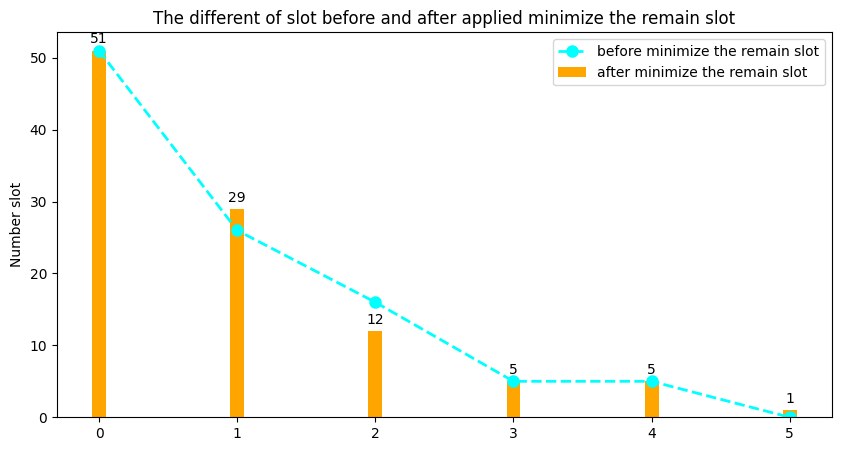

In [149]:
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))

rects0 = ax.bar(x, after_values, width, label='after minimize the remain slot', color="orange")

ax.plot(labels, before_values, color ='cyan', markeredgewidth=3, linewidth = 2, marker="o", linestyle = "--", label = "before minimize the remain slot")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number slot')
ax.set_title('The different of slot before and after applied minimize the remain slot')
ax.set_xticks(x, labels) # show to tick in the horizontal axis
ax.legend()

ax.bar_label(rects0, padding=3)

plt.show()

In [1]:
###################################################################################

## [validation] Comparing result Bestco and Scheduling system

In [24]:
"""
1 Literature
2 math
3 en
4 science
5 social science
6 personal science
7 personal social science
8 @will
9 ―
10 BW
11 EN speaking
12 science / social science : P
13 personal lit
14 personal math
15 personal EN
"""

"""
for now, you can count math & personal math both 1:3. science & social science & lit = 1:9
"""

SUBJECT_MAPPING_CONVERT = ["", "literature", "math", "english", "science", "social_science", "science",
                           "social_science", "",
                           "", "", "english", "", "literature", "math", "english"]

In [30]:
bestco_result_df = pd.read_csv("../../data/bestco/output/bestco_run_result.csv")
manabie_result_df = pd.read_csv("../../data/bestco/output/result_large_20230419.csv")

In [31]:
day_df = pd.read_csv("../../script/convert_bestco_format/dict/day_list.csv")
stu_df = pd.read_csv("../../script/convert_bestco_format/dict/stu_list.csv")
teacher_df = pd.read_csv("../../script/convert_bestco_format/dict/teacher_list.csv")


### Number available slot

In [32]:
manabie_result_df

,Unnamed: 0.1,Unnamed: 0,day,shift,subject,level,student,teacher,is_primary_slot,actual_subject,slot_type,is_prefer
0,0,0,9,6,literature,middle,st_4,Teacher_2,1,literature,seasonal_slot,0
1,1,1,9,8,literature,middle,st_4,Teacher_2,1,literature,seasonal_slot,0
2,2,2,9,5,english,middle,st_4,Teacher_4,1,english,seasonal_slot,0
3,3,3,9,8,literature,middle,st_5,Teacher_2,1,literature,seasonal_slot,0
4,4,4,9,9,literature+science+social_science,middle,st_6,Teacher_2,0,science,seasonal_slot,0
...,...,...,...,...,...,...,...,...,...,...,...,...
943,943,943,43,9,math,middle,st_24,Teacher_6,0,math,sd_slot,0
944,944,944,43,9,literature+science+social_science,middle,st_29,Teacher_2,0,social_science,sd_slot,0
945,945,945,43,9,literature+science+social_science,middle,st_36,Teacher_2,0,social_science,seasonal_slot,0
946,946,946,43,8,math,middle,st_48,Teacher_7,0,math,sd_slot,0


In [33]:
def manabie_to_bestco(manabie_result_df):
    tmp = manabie_result_df
    tmp["teacher_"] = tmp.apply(lambda row: "t_" + row["teacher"].split("_")[1], axis=1)
    
    # get student id
    tmp = tmp.merge(right=stu_df, how="left", left_on="student", right_on="student_idx") 

    # get date
    tmp = tmp.merge(right=day_df, how="left", left_on=["day", "shift"], right_on=["date_idx", "time_period"])

    # get teacher 
    tmp = tmp.merge(right=teacher_df, how="left", left_on="teacher_", right_on="teacher_idx")
    
    manabie_formated = tmp[["actual_subject", "level", "student_id","teacher_id", "date", "time_period" ,"is_primary_slot"]]
    manabie_formated = manabie_formated.rename(columns={"actual_subject" : "subject"})
    
    return manabie_formated

In [34]:
manabie_formated = manabie_to_bestco(manabie_result_df)
manabie_formated.drop_duplicates()

<ipython-input-33-6bf236a6024b>:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  tmp = tmp.merge(right=teacher_df, how="left", left_on="teacher_", right_on="teacher_idx")


,subject,level,student_id,teacher_id,date,time_period,is_primary_slot
0,literature,middle,2019000529,A002420,2022-07-25 0:00:00,6,1
1,literature,middle,2019000529,A002420,2022-07-25 0:00:00,8,1
2,english,middle,2019000529,A003268,2022-07-25 0:00:00,5,1
3,literature,middle,2019001830,A002420,2022-07-25 0:00:00,8,1
4,science,middle,2019003147,A002420,2022-07-25 0:00:00,9,0
...,...,...,...,...,...,...,...
943,math,middle,2021001625,A003473,2022-08-28 0:00:00,9,0
944,social_science,middle,2021002655,A002420,2022-08-28 0:00:00,9,0
945,social_science,middle,2021002806,A002420,2022-08-28 0:00:00,9,0
946,math,middle,2022000953,A003888,2022-08-28 0:00:00,8,0


In [35]:
bestco_result_df["subject_name"] = bestco_result_df.apply(lambda row: SUBJECT_MAPPING_CONVERT[row["subject_id"]], axis=1)
bestco_result_nor_df = bestco_result_df[bestco_result_df["subject_name"] != ""]
bestco_result_nor_df.drop_duplicates()

,year,period,center_num,date,time_period,allocation_num,teacher_id,student_id,subject_id,sd_or_not,作成者ＩＤ,作成日,更新者ＩＤ,更新日,Unnamed: 14,Unnamed: 15,Unnamed: 16,subject_name
0,2022,1,770,2022-07-23 0:00:00,5,1,A004253,2022000754,2,NaN,system,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math
1,2022,1,770,2022-07-23 0:00:00,5,1,A004354,2022001048,2,NaN,system,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math
2,2022,1,770,2022-07-23 0:00:00,5,2,A004354,2022000941,3,NaN,system,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english
3,2022,1,770,2022-07-23 0:00:00,5,3,A004354,2020000836,3,1.0,system,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english
5,2022,1,770,2022-07-23 0:00:00,6,1,A002421,2022001048,4,NaN,system,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,2022,1,770,2022-08-26 0:00:00,10,2,A003473,2022000941,3,1.0,system,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english
1037,2022,1,770,2022-08-26 0:00:00,10,2,A003888,2021001625,3,1.0,system,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english
1038,2022,1,770,2022-08-26 0:00:00,10,2,A004253,2020003039,3,1.0,system,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english
1039,2022,1,770,2022-08-26 0:00:00,10,3,A003888,2021003469,3,1.0,system,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english


In [36]:
# manabie result is different with bestco 

manabie_formated.merge(right=bestco_result_nor_df, 
                       how="left",
                       left_on=["student_id", "teacher_id", "date", "time_period", "subject"], 
                       right_on=["student_id", "teacher_id", "date", "time_period", "subject_name"]).query("period.isnull()", engine="python")

,subject,level,student_id,teacher_id,date,time_period,is_primary_slot,year,period,center_num,...,subject_id,sd_or_not,作成者ＩＤ,作成日,更新者ＩＤ,更新日,Unnamed: 14,Unnamed: 15,Unnamed: 16,subject_name
0,literature,middle,2019000529,A002420,2022-07-25 0:00:00,6,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,literature,middle,2019000529,A002420,2022-07-25 0:00:00,8,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,english,middle,2019000529,A003268,2022-07-25 0:00:00,5,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,literature,middle,2019001830,A002420,2022-07-25 0:00:00,8,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,science,middle,2019003147,A002420,2022-07-25 0:00:00,9,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,math,middle,2021001625,A003473,2022-08-28 0:00:00,9,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,social_science,middle,2021002655,A002420,2022-08-28 0:00:00,9,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
945,social_science,middle,2021002806,A002420,2022-08-28 0:00:00,9,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
946,math,middle,2022000953,A003888,2022-08-28 0:00:00,8,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# bestco result is different with manabie system

bestco_result_nor_df.merge(right=manabie_formated, 
                       how="left",
                       right_on=["student_id", "teacher_id", "date", "time_period", "subject"], 
                       left_on=["student_id", "teacher_id", "date", "time_period", "subject_name"]).query("level.isnull()", engine="python")

,year,period,center_num,date,time_period,allocation_num,teacher_id,student_id,subject_id,sd_or_not,...,作成日,更新者ＩＤ,更新日,Unnamed: 14,Unnamed: 15,Unnamed: 16,subject_name,subject,level,is_primary_slot
0,2022,1,770,2022-07-23 0:00:00,5,1,A004253,2022000754,2,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math,NaN,NaN,NaN
1,2022,1,770,2022-07-23 0:00:00,5,1,A004354,2022001048,2,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math,NaN,NaN,NaN
2,2022,1,770,2022-07-23 0:00:00,5,2,A004354,2022000941,3,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN
3,2022,1,770,2022-07-23 0:00:00,5,3,A004354,2020000836,3,1.0,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN
4,2022,1,770,2022-07-23 0:00:00,6,1,A002421,2022001048,4,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2022,1,770,2022-08-26 0:00:00,10,2,A003473,2022000941,3,1.0,...,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN
890,2022,1,770,2022-08-26 0:00:00,10,2,A003888,2021001625,3,1.0,...,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN
891,2022,1,770,2022-08-26 0:00:00,10,2,A004253,2020003039,3,1.0,...,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN
892,2022,1,770,2022-08-26 0:00:00,10,3,A003888,2021003469,3,1.0,...,2022-07-08 0:01:58,NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN


In [38]:
# result from manabie and bestco is the same 

bestco_result_nor_df.merge(right=manabie_formated, 
                       how="inner",
                       right_on=["student_id", "teacher_id", "date", "time_period", "subject"], 
                       left_on=["student_id", "teacher_id", "date", "time_period", "subject_name"])

,year,period,center_num,date,time_period,allocation_num,teacher_id,student_id,subject_id,sd_or_not,...,作成日,更新者ＩＤ,更新日,Unnamed: 14,Unnamed: 15,Unnamed: 16,subject_name,subject,level,is_primary_slot
0,2022,1,770,2022-07-25 0:00:00,6,1,A003268,2021000009,2,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math,math,middle,1
1,2022,1,770,2022-07-27 0:00:00,6,1,A004354,2021002747,2,1.0,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,math,math,middle,1
2,2022,1,770,2022-07-29 0:00:00,5,2,A003268,2022000953,3,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english,english,middle,1
3,2022,1,770,2022-07-29 0:00:00,7,3,A002421,2022000829,4,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science,science,middle,1
4,2022,1,770,2022-08-01 0:00:00,8,2,A002421,2021000077,4,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science,science,middle,1
5,2022,1,770,2022-08-03 0:00:00,6,2,A002420,2021000696,4,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science,science,middle,1
6,2022,1,770,2022-08-04 0:00:00,6,1,A002420,2022000953,4,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,science,science,middle,1
7,2022,1,770,2022-08-04 0:00:00,6,3,A002420,2021000077,5,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,social_science,social_science,middle,1
8,2022,1,770,2022-08-04 0:00:00,7,2,A004354,2020003037,3,NaN,...,2022-07-08 0:01:56,NaN,NaN,NaN,NaN,NaN,english,english,middle,1
9,2022,1,770,2022-08-19 0:00:00,9,1,A004253,2021003429,3,1.0,...,2022-07-08 0:01:57,NaN,NaN,NaN,NaN,NaN,english,english,middle,0


### How is different 

    *1. from the result*
        1.1 manually is better? does that have any slot conflict the rule? 
        1.2 which pattern does manabie system missing?
        1.3 how to improve and timeline? 



In [14]:
# bestco to manabie idx

In [39]:
def bestco_to_manabie(bestco_result_df):
    bestco_result_df["subject_name"] = bestco_result_df.apply(lambda row: SUBJECT_MAPPING_CONVERT[row["subject_id"]], axis=1)
    bestco_result_nor_df = bestco_result_df[bestco_result_df["subject_name"] != ""]
    
    tmp2 = bestco_result_nor_df
    tmp2 = tmp2.merge(right=stu_df, how="left", left_on="student_id", right_on="student_id")

    tmp2 = tmp2.merge(right=day_df[["date", "date_idx"]].drop_duplicates(), how="left", left_on=["date"], right_on=["date"])

    tmp2 = tmp2.merge(right=teacher_df, how="left", left_on="teacher_id", right_on="teacher_id")

    tmp2 = tmp2[["teacher_idx", "student_idx", "subject_name", "date_idx", "time_period", "sd_or_not"]]
    tmp2 = tmp2.rename(columns={"teacher_idx": "teacher", "student_idx": "student", "date_idx":"day", "time_period":"shift", "subject_name":"actual_subject"})
    tmp2["subject"] = tmp2["actual_subject"]
    
    return tmp2

In [41]:
tmp2 = bestco_to_manabie(bestco_result_df)
tmp2

,teacher,student,actual_subject,day,shift,sd_or_not,subject
0,t_9,st_44,math,7,5,NaN,math
1,t_10,st_49,math,7,5,NaN,math
2,t_10,st_47,english,7,5,NaN,english
3,t_10,st_8,english,7,5,1.0,english
4,t_3,st_49,science,7,6,NaN,science
...,...,...,...,...,...,...,...
889,t_6,st_47,english,41,10,1.0,english
890,t_7,st_24,english,41,10,1.0,english
891,t_9,st_12,english,41,10,1.0,english
892,t_7,st_39,english,41,10,1.0,english


In [17]:
tmp2.to_csv("bestco_result_nor.csv")

#### result unit test
check result from bestco with constraints:

1. teacher teach 2 class at the same time

    ERROR: Teacher t_10 teach multi slot at 7 - shift 5 
    => seem that can ignore, subject is english and math, which is have the same ratio 
    
2. Student study more than slot which they register

    5 not less than or equal to 0 : ERROR: student st_2 is learn more than slot of english which they register
    
    ERROR: student st_2 - 2019000419 is learn more than slot of english which they register. applied 5 - register 0
    
    ERROR: student st_2 - 2019000419 is learn more than slot of math which they register. applied 4 - register 0

    ERROR: student st_9 - 2020001655 is learn more than slot of english which they register. applied 3 - register 0
    
    ERROR: student st_10 - 2020002812 is learn more than slot of math which they register. applied 4 - register 0.0
    
    ERROR: student st_14 - 2021000065 is learn more than slot of english which they register. applied 4 - register 0
    
    ERROR: student st_14 - 2021000065 is learn more than slot of math which they register. applied 16 - register 0
        
    ERROR: student st_30 - 2021002672 is learn more than slot of math which they register. applied 8 - register 0

In [21]:
# ERROR: Teacher t_10 teach multi slot at 7 - shift 5 
# => the result is good

bestco_result_df[(bestco_result_df["teacher_id"] == "A004354") & (bestco_result_df["date"] == "2022-07-23 0:00:00") & (bestco_result_df["time_period"] == 5)]

,year,period,center_num,date,time_period,allocation_num,teacher_id,student_id,subject_id,sd_or_not,subject_name
1,2022,1,770,2022-07-23 0:00:00,5,1,A004354,2022001048,2,NaN,math
2,2022,1,770,2022-07-23 0:00:00,5,2,A004354,2022000941,3,NaN,english
3,2022,1,770,2022-07-23 0:00:00,5,3,A004354,2020000836,3,1.0,english


In [22]:
bestco_result_df[(bestco_result_df["student_id"] == 2019000419)]

,year,period,center_num,date,time_period,allocation_num,teacher_id,student_id,subject_id,sd_or_not,subject_name
49,2022,1,770,2022-07-23 0:00:00,10,3,A003920,2019000419,14,NaN,math
101,2022,1,770,2022-07-25 0:00:00,10,1,A004253,2019000419,14,NaN,math
213,2022,1,770,2022-07-27 0:00:00,10,2,A004253,2019000419,14,NaN,math
359,2022,1,770,2022-08-01 0:00:00,9,3,A003388,2019000419,14,NaN,math
470,2022,1,770,2022-08-03 0:00:00,10,1,A003388,2019000419,15,1.0,english
515,2022,1,770,2022-08-04 0:00:00,9,2,A003388,2019000419,15,1.0,english
674,2022,1,770,2022-08-09 0:00:00,10,1,A003888,2019000419,15,1.0,english
833,2022,1,770,2022-08-19 0:00:00,10,1,A003888,2019000419,15,1.0,english
981,2022,1,770,2022-08-24 0:00:00,10,2,A003388,2019000419,15,1.0,english


#### number subject finish subject

In [42]:
# manabie run
result_path = "../../data/bestco/output/manabie_run_final.csv"
input_stu_path = "../../data/bestco/input/formated/student_course.csv"

df = get_number_register_and_applie_slot(input_stu_course_path=input_stu_path, result_path=result_path)

In [34]:
df["remain"].value_counts()

0.0     70
2.0     17
5.0     11
4.0     11
1.0      8
12.0     4
7.0      3
3.0      3
8.0      2
10.0     2
9.0      1
Name: remain, dtype: int64

In [43]:
tmp2 = bestco_to_manabie(bestco_result_df)
tmp2.to_csv("./bestco_result_formated.csv")

In [44]:
# bestco result
result_path = "./bestco_result_formated.csv"
input_stu_path = "../../data/bestco/input/formated/student_course.csv"

df_re = get_number_register_and_applie_slot(input_stu_course_path=input_stu_path, result_path=result_path)

In [45]:
df_re["remain"].value_counts()

0.0     80
1.0     27
2.0      9
3.0      5
4.0      4
5.0      3
10.0     2
7.0      2
Name: remain, dtype: int64

In [12]:
###########################################################

## [REFORMAT] Convert to Gauss format

In [69]:
import pandas as pd
import numpy as np
import copy

In [77]:
def manabie_to_bestco(manabie_result_df):
    tmp = manabie_result_df
    tmp["teacher_"] = tmp.apply(lambda row: "t_" + row["teacher"].split("_")[1], axis=1)
    
    # get student id
    tmp = tmp.merge(right=stu_df, how="left", left_on="student", right_on="student_idx") 

    # get date
    tmp = tmp.merge(right=day_df, how="left", left_on=["day", "shift"], right_on=["date_idx", "time_period"])

    # get teacher 
    tmp = tmp.merge(right=teacher_df, how="left", left_on="teacher_", right_on="teacher_idx")
    
    manabie_formated = tmp[["actual_subject", "level", "student_id","teacher_id", "date", "time_period" ,"is_primary_slot", "slot_type"]]
    manabie_formated = manabie_formated.rename(columns={"actual_subject" : "subject"})
    
    return manabie_formated

In [78]:
manabie_result_df = pd.read_csv("../../src/OR_auto_timeschedule/OR_tool/bestco/result_large.csv")

In [79]:
day_df = pd.read_csv("../../script/convert_bestco_format/dict/day_list.csv")
stu_df = pd.read_csv("../../script/convert_bestco_format/dict/stu_list.csv")
teacher_df = pd.read_csv("../../script/convert_bestco_format/dict/teacher_list.csv")
teacher_avail_time = pd.read_csv("/home/vong/Documents/Documents/src/backend/internal/scheduling/data/bestco/input/raw/teacher_available_slot_master.csv")
student_avail_time = pd.read_csv("/home/vong/Documents/Documents/src/backend/internal/scheduling/data/bestco/input/raw/applied_slot.csv")

In [80]:
manabie_formated = manabie_to_bestco(manabie_result_df)
manabie_formated

<ipython-input-77-eb10ee7a236b>:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  tmp = tmp.merge(right=teacher_df, how="left", left_on="teacher_", right_on="teacher_idx")


,subject,level,student_id,teacher_id,date,time_period,is_primary_slot,slot_type
0,literature,middle,2019000529,A002420,2022-07-25 0:00:00,6,1,seasonal_slot
1,literature,middle,2019000529,A002420,2022-07-25 0:00:00,8,1,seasonal_slot
2,english,middle,2019000529,A003268,2022-07-25 0:00:00,5,1,seasonal_slot
3,literature,middle,2019001830,A002420,2022-07-25 0:00:00,8,1,seasonal_slot
4,science,middle,2019003147,A002420,2022-07-25 0:00:00,9,0,seasonal_slot
...,...,...,...,...,...,...,...,...
943,math,middle,2021001625,A003473,2022-08-28 0:00:00,9,0,sd_slot
944,social_science,middle,2021002655,A002420,2022-08-28 0:00:00,9,0,sd_slot
945,social_science,middle,2021002806,A002420,2022-08-28 0:00:00,9,0,seasonal_slot
946,math,middle,2022000953,A003888,2022-08-28 0:00:00,8,0,sd_slot


### convert to gauss format

In [81]:
def get_gauss_format(manabie_fomated, day_df, teacher_df, teacher_avail_time):
    manabie_formated_name = manabie_formated.merge(right=student_avail_time[["student_id","student_name", "grade"]], left_on="student_id", right_on="student_id")
    col_list = teacher_df["teacher_id"].drop_duplicates().to_list()
    
    pe = copy.deepcopy(day_df)
    
    col_list = teacher_df["teacher_id"].drop_duplicates().to_list()
    for col in col_list:
        pe[col] = [ "" ] * len(pe)
        
    for i in range(len(pe)):
        if pe.iloc[[i]].reset_index()["open_or_not"][0] == 1:
            # print("*** here ****")
            date = pe.iloc[[i]].reset_index()["date"][0]
            time_period = pe.iloc[[i]].reset_index()["time_period"][0]
            
            for teacher_id in col_list:
                stu_id_list = manabie_formated_name[(manabie_formated_name["teacher_id"] == teacher_id) & (manabie_formated_name["date"] == date) & (manabie_formated_name["time_period"] == time_period)]["student_id"].drop_duplicates().to_list()
                stu_name_list = manabie_formated_name[(manabie_formated_name["teacher_id"] == teacher_id) & (manabie_formated_name["date"] == date) & (manabie_formated_name["time_period"] == time_period)]["student_name"].drop_duplicates().to_list()
                stu_grade_list = manabie_formated_name[(manabie_formated_name["teacher_id"] == teacher_id) & (manabie_formated_name["date"] == date) & (manabie_formated_name["time_period"] == time_period)]["grade"].to_list()
                slot_type_list = manabie_formated_name[(manabie_formated_name["teacher_id"] == teacher_id) & (manabie_formated_name["date"] == date) & (manabie_formated_name["time_period"] == time_period)]["slot_type"].to_list()
                stu_sub_list = manabie_formated_name[(manabie_formated_name["teacher_id"] == teacher_id) & (manabie_formated_name["date"] == date) & (manabie_formated_name["time_period"] == time_period)]["subject"].to_list()

                assert len(stu_name_list) == len(stu_grade_list) 
                assert len(stu_grade_list) == len(slot_type_list)
                assert len(stu_sub_list) == len(slot_type_list)

                stu_list = [] 

                for stu_idx in range(0, len(stu_name_list)):
                    stu = "||".join([stu_name_list[stu_idx], f"{stu_grade_list[stu_idx]}", f"{stu_sub_list[stu_idx]}", f"{slot_type_list[stu_idx]}"])
                    stu_list.append(stu)
                    # print(stu_list)
                    
                if len(stu_id_list) >= 1:  
                    pe.at[i, teacher_id] = "**".join([str(x) for x in stu_list]) 
                else:
                    pe.at[i, teacher_id] = "" if len(teacher_avail_time[(teacher_avail_time["date"] == date) & \
                                                              (teacher_avail_time["teacher_id"] == teacher_id) & \
                                                              (teacher_avail_time["time_period"] == time_period)].reset_index()["available_or_not"]) == 0 \
                                            else teacher_avail_time[(teacher_avail_time["date"] == date) & \
                                                              (teacher_avail_time["teacher_id"] == teacher_id) & \
                                                              (teacher_avail_time["time_period"] == time_period)].reset_index()["available_or_not"][0]
                # print(pe.iloc[i][teacher_id])
                # print(pe.iloc[i]["date"] == date)
    return pe

In [82]:
gauss_format = get_gauss_format(manabie_formated, day_df, teacher_df, teacher_avail_time)
gauss_format

,Unnamed: 0,date,time_period,open_or_not,date_idx,129,A002420,A002421,A003268,A003388,A003473,A003888,A003920,A004253,A004354,A004710
0,0,2022-07-16 0:00:00,1,0,0,,,,,,,,,,,
1,1,2022-07-16 0:00:00,2,0,0,,,,,,,,,,,
2,2,2022-07-16 0:00:00,3,0,0,,,,,,,,,,,
3,3,2022-07-16 0:00:00,4,0,0,,,,,,,,,,,
4,4,2022-07-16 0:00:00,5,0,0,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,454,2022-08-30 0:00:00,5,0,45,,,,,,,,,,,
456,455,2022-08-30 0:00:00,6,0,45,,,,,,,,,,,
457,456,2022-08-30 0:00:00,7,0,45,,,,,,,,,,,
458,457,2022-08-30 0:00:00,8,0,45,,,,,,,,,,,


In [84]:
gauss_format.to_csv("re_3.csv")

### check the level in each class

In [86]:
student_avail_time = pd.read_csv("/home/vong/Documents/Documents/src/backend/internal/scheduling/data/bestco/input/raw/applied_slot.csv")
student_avail_time[["student_id","student_name"]]

,student_id,student_name
0,2018002901,船越 結子
1,2019000419,板橋 一寿
2,2019000422,山田 浩太
3,2019000529,髙橋 永汰
4,2019000847,佐々木 陽斗
...,...,...
58,2022001737,小野 真斗
59,2022002021,齋藤 妃菜
60,2022002082,山下 瞭輔
61,2022002171,尾形 柚乃


In [87]:
manabie_formated_name = manabie_formated.merge(right=student_avail_time[["student_id","student_name", "grade"]], left_on="student_id", right_on="student_id")


In [88]:
date=manabie_formated_name["date"].drop_duplicates().to_list()
period=manabie_formated_name["time_period"].drop_duplicates().to_list()
teacher_list= manabie_formated_name["teacher_id"].drop_duplicates().to_list()

for i in range(len(manabie_formated_name)):
    teacher = manabie_formated_name["teacher_id"][i]
    day = manabie_formated_name["date"][i]
    shift = manabie_formated_name["time_period"][i]
    
    tmp = manabie_formated_name.groupby(by=["teacher_id", "date", "time_period"]).get_group((teacher, day, shift)).reset_index()
    # print(tmp["level"].to_list())
    

## [Ratio] Calculate number ratio student in each slot

In [89]:
import pandas as pd

In [90]:
gauss_format = pd.read_csv("re_3.csv")
teacher_df = pd.read_csv("../../script/convert_bestco_format/dict/teacher_list.csv")

In [91]:
def get_ratio(gauss_format, teacher_df):
    total_stu_3 = 0
    total_slot_3 = 0
    
    total_stu_9 = 0
    total_slot_9 = 0
    
    total_stu = 0
    total_slot = 0
    
    teacher_list = teacher_df["teacher_id"].drop_duplicates().to_list()
    for i in range(len(gauss_format)):
        for teacher_id in range(len(teacher_list)):
            if "||" in str(gauss_format.iloc[[i]].reset_index()[teacher_list[teacher_id]][0]):
                num_stu = len(gauss_format.iloc[[i]].reset_index()[teacher_list[teacher_id]][0].split("**"))

                if (num_stu >=0) & (num_stu <=3):
                    total_slot_3 += 1
                    total_stu_3 += num_stu
                elif (num_stu > 3): 
                    total_slot_9 += 1
                    total_stu_9 += num_stu
                    
                if (num_stu >=2) & (num_stu <=3):
                    total_slot += 1
                    total_stu += num_stu
                elif (num_stu >= 3) & (num_stu<=6): 
                    total_slot += 2
                    total_stu += num_stu
                elif (num_stu >= 6) & (num_stu<=9): 
                    total_slot += 3
                    total_stu += num_stu
               
                    
    return [total_stu_3/total_slot_3, total_stu_9/total_slot_9, total_stu/total_slot, total_stu, total_slot]

In [92]:
get_ratio(gauss_format, teacher_df)

[1.64, 5.909090909090909, 2.4285714285714284, 408, 168]